In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def plot_results(run_ids):
    tr_dict = {'avg_length':'avg_req_length','avg_price':'avg_req_price','avg_num_trips':'num_req_completed','avg_online_ratio':'online_ratio','waiting_per_empty':'waiting_per_empty'}

    data = [pd.read_csv('results/run_'+run_id+'_per_taxi_aggregates.csv',index_col=0) for run_id in run_ids]
    distr = [json.load(open('results/run_'+run_id+'_per_taxi_distributions.json')) for run_id in run_ids]
    for column in [c for c in data[0].columns if ((c[0]=='a') or (c[0]=='w'))]:
        f, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,5))
        
        column2 = tr_dict[column]
        
        min_distr = np.nanmin([elem for d2 in distr for elem in d2[column2]])
        max_distr = np.nanmax([elem for d2 in distr for elem in d2[column2]])
        bin_edges = np.linspace(min_distr,max_distr,20)
        
        for i in range(len(data)):
            d1 = data[i]
            ax1.plot(d1['timestamp'],d1[column],label=run_ids[i])
            ax1.set_xlabel('Time')
            ax1.set_ylabel(column)
            ax1.legend()

            d2 = distr[i]
            y,x=np.histogram([elem for elem in d2[column2] if not np.isnan(elem)],bins=bin_edges)
            ax2.plot(x[1:],y,'-',label=run_ids[i])
            ax2.legend()
            ax2.set_xlabel(column2)
            ax2.set_ylabel('N('+column2+')')

# 500 taxis

In [3]:
run_ids = ['0525_'+str(i)+'_priced' for i in range(1,4)]
#plot_results(run_ids)

# 200 taxis

In [4]:
run_ids = ['0525_'+str(i)+'_priced' for i in range(4,7)]
#plot_results(run_ids)

# Batch run visualization

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size']=14
plt.rcParams['figure.figsize']=10,12
import os
import json

In [6]:
def collect_results(base):
    """
    Given a base name, this function creates a dictionary listing all three result files
    corresponding to the config files.
    """
    data_structure = {}

    for f in os.listdir('configs'):
        if f[0:10]==base:
            #print(f)
            run_id = f.split('.')[0]
            data_structure[run_id]={}
            for r in os.listdir('results'):
                if run_id in r:
                    #print('\t'+r)
                    if r[-3:]=='csv':
                        data_structure[run_id]['agg']='results/'+r
                    elif 'request' in r.split('_'):
                        data_structure[run_id]['req']='results/'+r
                    elif 'taxi' in r.split('_'):
                        data_structure[run_id]['taxi']='results/'+r
    return data_structure

In [7]:
# collecting the results of the batch run
data_structure = collect_results('0604_base_')

In [10]:
# this part is only needed because of the errors in the original aggregate metrics function
from city_model import Simulation
from city_model import Measurements
s = Simulation(**json.load(open('configs/'+list(data_structure.keys())[1]+'.conf')))
m = Measurements(s)

for key in data_structure:
    t = json.load(open(data_structure[key]['taxi']))
    r = json.load(open(data_structure[key]['req']))
    data_structure[key]['agg'] = pd.Series(m.read_aggregated_metrics(t,r))

In [11]:
def extract_info(k):
    """
    Given a run_id, this function extracts aggregate measures merged with configuration data.
    Returns a pandas.Series.
    """
    cols = ["num_taxis","matching","d","R","avg_trip_avg_price","std_trip_avg_price","entropy_ratio_online","avg_ratio_online","avg_ratio_cruising","avg_request_last_waiting_times"]
    r1 = data_structure[k]['agg']
    conf = json.load(open('configs/'+k+'.conf'))
    conf['R']=round(conf['request_rate']*8/conf['num_taxis'],2)
    conf['d']=round(np.sqrt(8e6/conf['num_taxis']),0)
    r2 = pd.Series(conf)
    return pd.concat([r1,r2])[cols]

In [12]:
# creating a dataframe of the fixed taxi density data
df = pd.DataFrame([extract_info(k) for k in data_structure if 'fixed_taxis' in k])
df = df[['matching','R',"avg_trip_avg_price","std_trip_avg_price","entropy_ratio_online","avg_ratio_cruising"]]

In [13]:
# human readable legends
algnames = {'baseline_random_user_nearest_taxi':'nearest','baseline_random_user_random_taxi':'random','levelling2_random_user_nearest_poorest_taxi_w_waiting_limit':'poorest'}
coldict = { "avg_trip_avg_price":"avg_income", "std_trip_avg_price":"std_income"}

In [14]:
df['matching']=df['matching'].map(algnames)

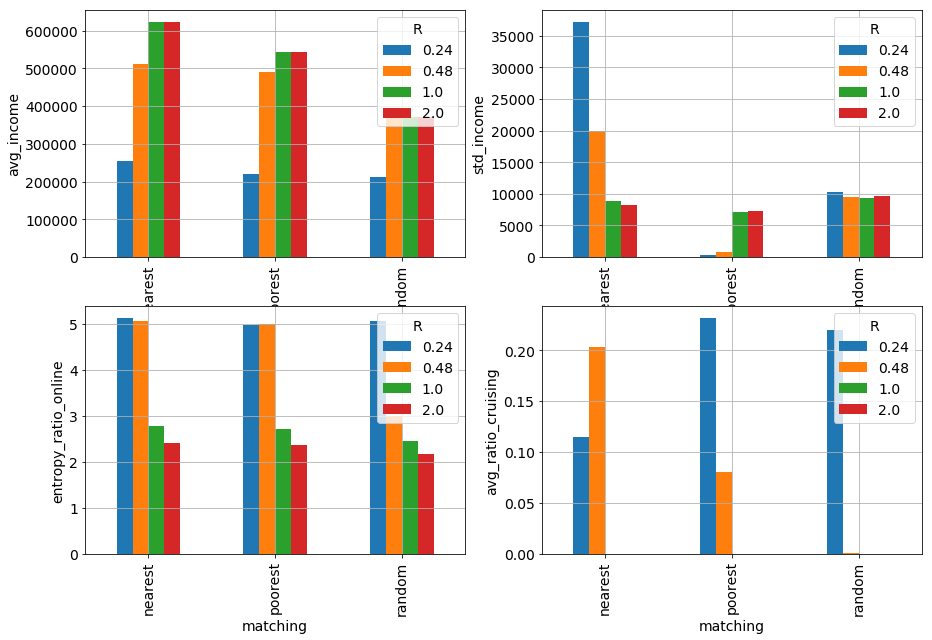

In [15]:
fig,ax = plt.subplots(nrows=2,ncols=2)

for i,c in enumerate(["avg_trip_avg_price","std_trip_avg_price","entropy_ratio_online","avg_ratio_cruising"]):
    pd.pivot_table(df,index='matching',columns='R',values=c).plot(kind='bar',ax = ax[int(i/2),i%2],figsize=(15,10))
    ax[int(i/2),i%2].set_ylabel(coldict.get(c,c))
    ax[int(i/2),i%2].grid()

Interesting (fixed number of taxis in the system):
    * top left: Average total income per taxis at different request-to-taxi ratios.
        * There is a saturation of the total income. If the number of taxis are fixed, the capacity of the system saturates. Even if there are more passengers, they cannot increase their income any more.
        * The total income does not seem to go linearly with the number of requests.
        * The performance of the algorithms in terms of total income decreases in the order of the x axis at all request ratios.
        * The 'poorest' algorithm is closer to the 'nearest' one than to the random one in this measure.
    * top right: Standard deviation of total income per taxis at different request-to-taxi ratios.
        * These should be compared to the average incomes, otherwise their height can be deceptive.
        * **It is remarkable how the poorest algorithm decreases the standard deviation at low request-to-taxi ratios!**
        * In the saturated cases, the poorest algorithm does not have that much decreasing effect on the standard deviation.
    * bottom left: Information entropy of the distribution of online ratios at different request-to-taxi ratios.
        * Higher entropy means higher 'inequality', where this distribution is quite 'flat'.
        * I used 1000 bins for calculating the probability distribution, thus the maximum value would be at $\log(1000)\approx 7$. 
        * I don't really understand this figure, since the algorithms has almost no effect on the numbers.
    * bottom right: Cruising ratio at different request-to-taxi ratios.
        * In the saturated cases, cruising disappears.
        * Cruising time increases in the nearest algorithm for the second bar because of less waiting time at the base. If the request density is really-really low, cars do not move as much.

In [16]:
def extract_income_distr(k):
    cols = ["num_taxis","matching","d","R","trip_avg_price"]
    r1 = pd.Series(json.load(open(data_structure[k]['taxi'])))
    conf = json.load(open('configs/'+k+'.conf'))
    conf['R']=round(conf['request_rate']*8/conf['num_taxis'],2)
    conf['d']=round(np.sqrt(8e6/conf['num_taxis']),0)
    r2 = pd.Series(conf)
    return pd.concat([r1,r2])[cols]

In [17]:
df2 = pd.DataFrame([extract_income_distr(k) for k in data_structure if 'fixed_taxi' in k])
df2['matching'] = df2['matching'].map(algnames)
df2 = pd.pivot_table(df2,index='R',columns='matching',values='trip_avg_price',aggfunc=lambda x:x)

In [18]:
df2['min']=df2.apply(lambda row: min([min(row[c]) for c in ['nearest','poorest','random']]),axis=1)
df2['max']=df2.apply(lambda row: max([max(row[c]) for c in ['nearest','poorest','random']]),axis=1)

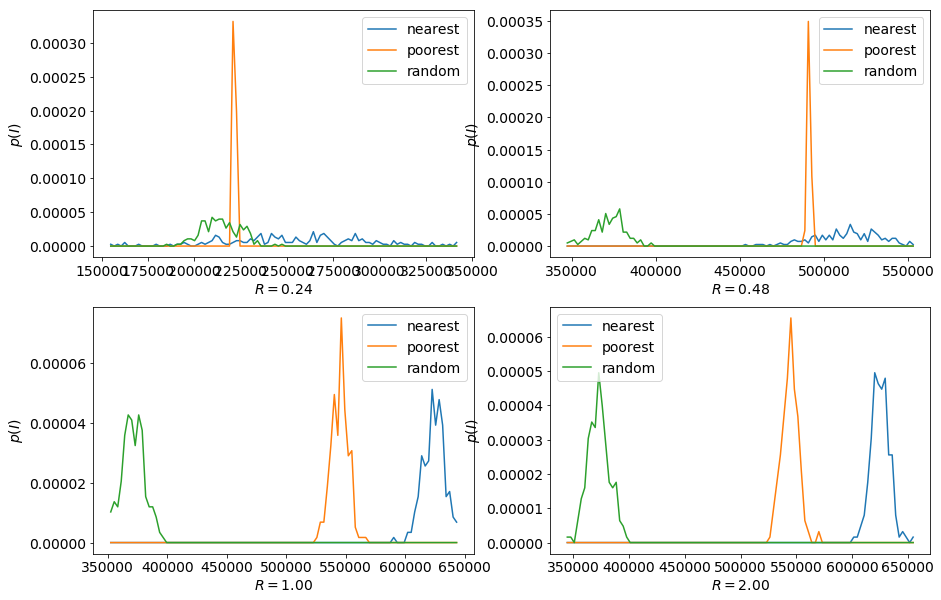

In [19]:
fig,ax = plt.subplots(nrows=2,ncols=2,figsize=(15,10))
for i,R in enumerate(df2.index):
    for c in ['nearest','poorest','random']:
        y,x = np.histogram(df2.loc[R][c],range=(df2.loc[R]['min'],df2.loc[R]['max']),bins=100,density=True)
        ax[int(i/2),i%2].plot(x[1:],y,label=c)
    ax[int(i/2),i%2].legend()
    ax[int(i/2),i%2].set_ylabel(r'$p(I)$')
    ax[int(i/2),i%2].set_xlabel(r'$R=%.2f$' % R)

Interesting:
    * At low densities, incomes become highly unequal in the nearest and random cases, out algorithm helps a lot in this case.
    * At high densities, it seems to be not that crucial.